In [1]:
import sys
sys.path.insert(0,"/Library/Python/2.7/site-packages")
#sys.path

import numpy as np
import scipy as sp
import pandas as pd
#print np.__version__
#print np.__file__

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from matplotlib import rcParams
#from matplotlib.dates import YearLocator, MonthLocator, DayLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib.collections as mplcoll
import matplotlib.colors as mplcolor
#print mpl.__version__
#print mpl.__file__

import json
from operator import itemgetter
%matplotlib inline

import datetime as DT

import MySQLdb

##  Load Generic Functions

In [2]:
%run 'new_user_activation_funcs.ipynb'

## Generic Procedure to do FFT and then plot some details

In [10]:
#
#
#  Do Fourier Transform and plot some details
#
#
def do_power_spectrum(thisx, thisy, powermax=None):
    
    # generic shit
    fig = plt.figure( figsize = (12.,20.))
    font = {'family':'Times New Roman', 'size':16} # 'weight' : 'bold',
    mpl.rc('font', **font)

    ax1= fig.add_subplot(3,1,1)
    ax2= fig.add_subplot(3,1,2)
    ax3= fig.add_subplot(3,1,3)


    # ----------------------------
    #
    #  compute fft
    #
    import scipy.fftpack

    Nyy = len(thisy)
    #print "N_yy=", Nyy
    yf = scipy.fftpack.fft(thisy)
    
    yfft = np.real(scipy.fftpack.ifft(yf))

    # calculate frequencies ...
    #  (this assumes equal spacing in thisx)
    freq = scipy.fftpack.fftfreq(len(thisy), thisx[1] - thisx[0])

    # make nice for plotting 
    idx = np.argsort(freq)
    freqsort = freq[idx]
    yfsort = yf[idx]


    # ----------------------------
    #
    #  plot #1 - top
    #
    #  raw signal
    #

    ax1.plot(thisx, thisy, '-k', linewidth=1.0)
    
    ax1.plot(thisx, yfft, ':b', linewidth=2.0)

    ax1.set_ylim([1.1*min(thisy) - 0.1*max(thisy), 1.1*max(thisy) - 0.1*min(thisy)])


    # ----------------------------
    #
    #  plot #2 - middle
    #
    #  absolute positive amplitude of components
    #         versus frequency
    #

    # full spectrum
    ax2.plot(freqsort, np.abs(yfsort), '-b', linewidth=2.0)

    # only the positive portion
    ax2.plot(freq[1:Nyy/2], np.abs(yf[1:Nyy/2]), ':r', linewidth=4.0)

    ax2.set_xlabel("Freq", fontsize=20)
    ax2.set_ylabel("|Amplitude|", fontsize=20)

    #ax2.set_xlim([-0.55,0.55])
    ax2.set_ylim([0.0,max(np.abs(yfsort))])


    # ----------------------------
    #
    #  plot #3 - bottom
    #
    #  power spectrum versus period
    #

    per = 1.0 / freq

    power = (np.abs(yf))**2
    powernorm = power / sum(power)
    #print powernorm
    #print max(powernorm)

    #ax3.plot(per[1:Nyy/2], 1.0/Nyy/Nyy * (np.abs(yf[1:Nyy/2]))**2, ':g', linewidth=4.0)
    #ax3.plot(per[1:Nyy/2], power[1:Nyy/2]/Nyy/Nyy, '-m', linewidth=4.0)

    ax3.plot(per[1:Nyy/2], powernorm[1:Nyy/2], ':g', linewidth=4.0)

    # show specific period (7 in this example)
    #ax3.plot([7.0,7.0],[-100,1e6],'-k',linewidth=1.0)

    ax3.set_xlabel("Period ()", fontsize=20)
    ax3.set_ylabel("Power (Fractional)", fontsize=20)

    if powermax is None:
        #powermax = max(per)
        powermax = max(per[1:Nyy/2])
    #print "powermax=", powermax
    ax3.set_xlim([0,powermax])

    ax3.set_ylim([0.0,max(powernorm[1:Nyy/2])])
    

##OK, now, let's compute some power spectra ...

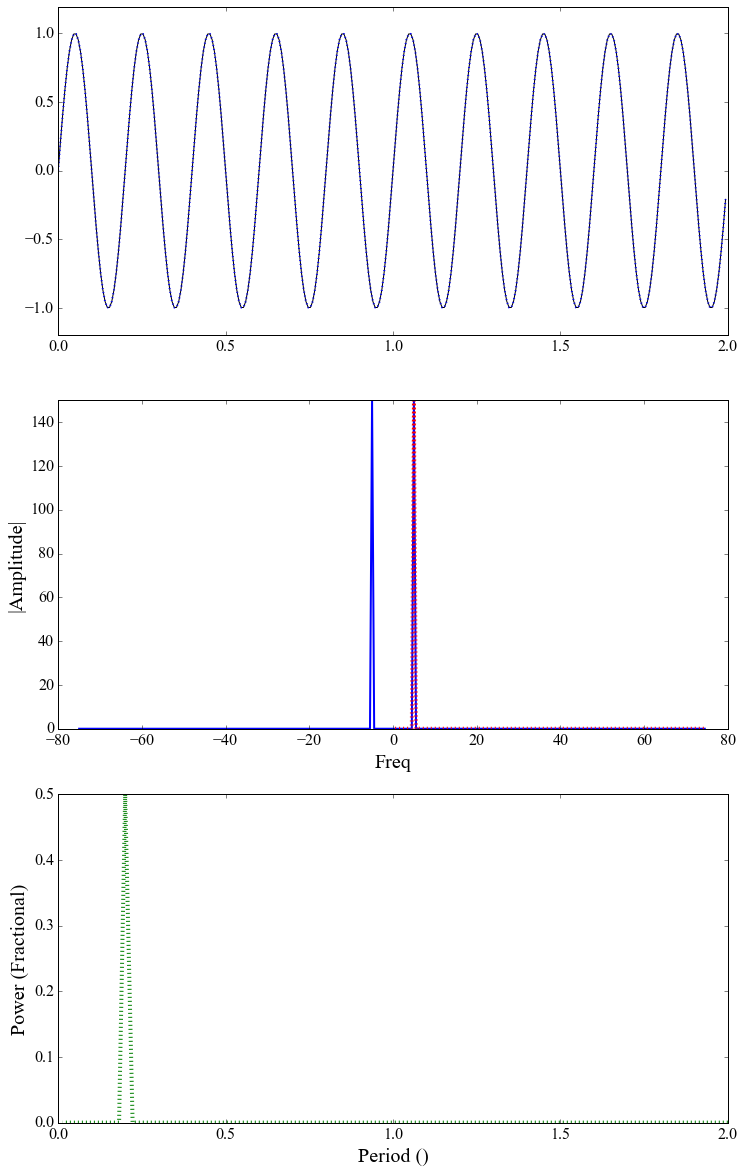

In [11]:
# test #1
#
# generic sine wave
#

N_points = 300
T_max = 2.0
T_min = 0.0
ff = 5;   # frequency of the signal
Fs = N_points / (T_max - T_min)  # sampling rate (data per second)
#print "Fs=", Fs
Ts = 1.0 / Fs; # sampling interval (in seconds)

x = np.arange(T_min,T_max,Ts) # time vector
y = np.sin(2*np.pi*ff*x)

do_power_spectrum(x, y)

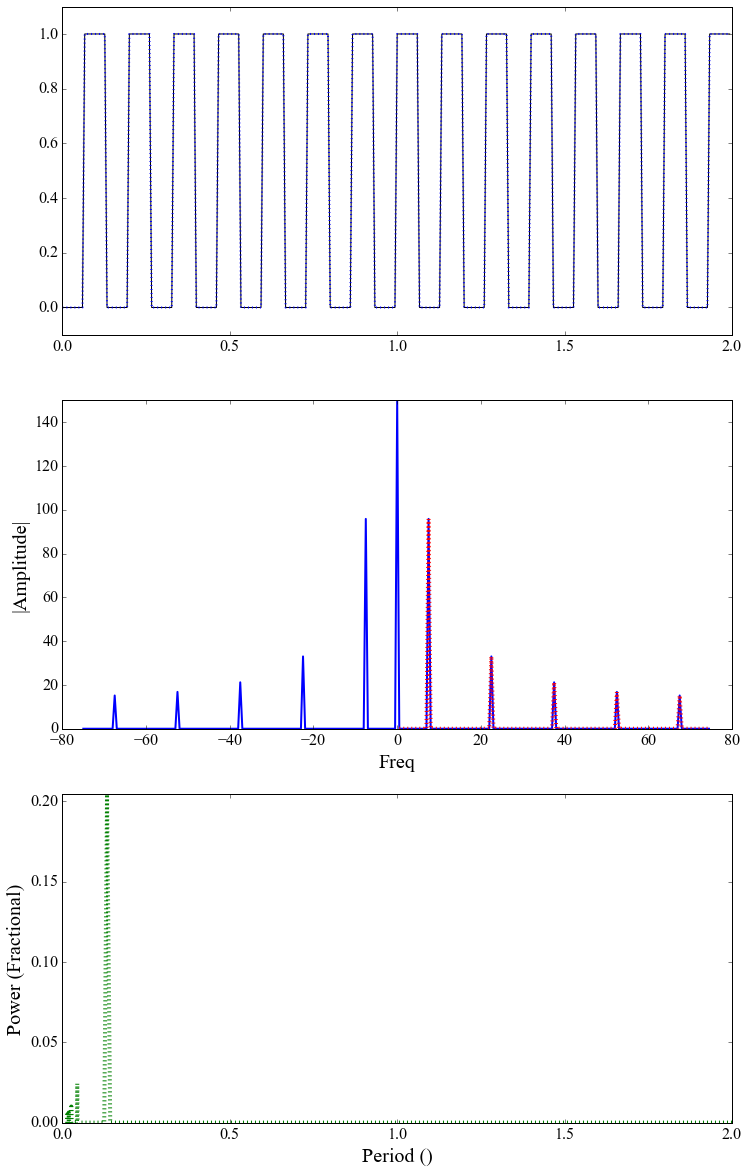

In [12]:
# test #2
#
# square wave - adopt above parameters
#

y = []

for i in range(N_points):
    if int(i/10) % 2:
        y.append(1)
    else:
        y.append(0)

#print len(x)
#print len(y)

do_power_spectrum(x, y)
        

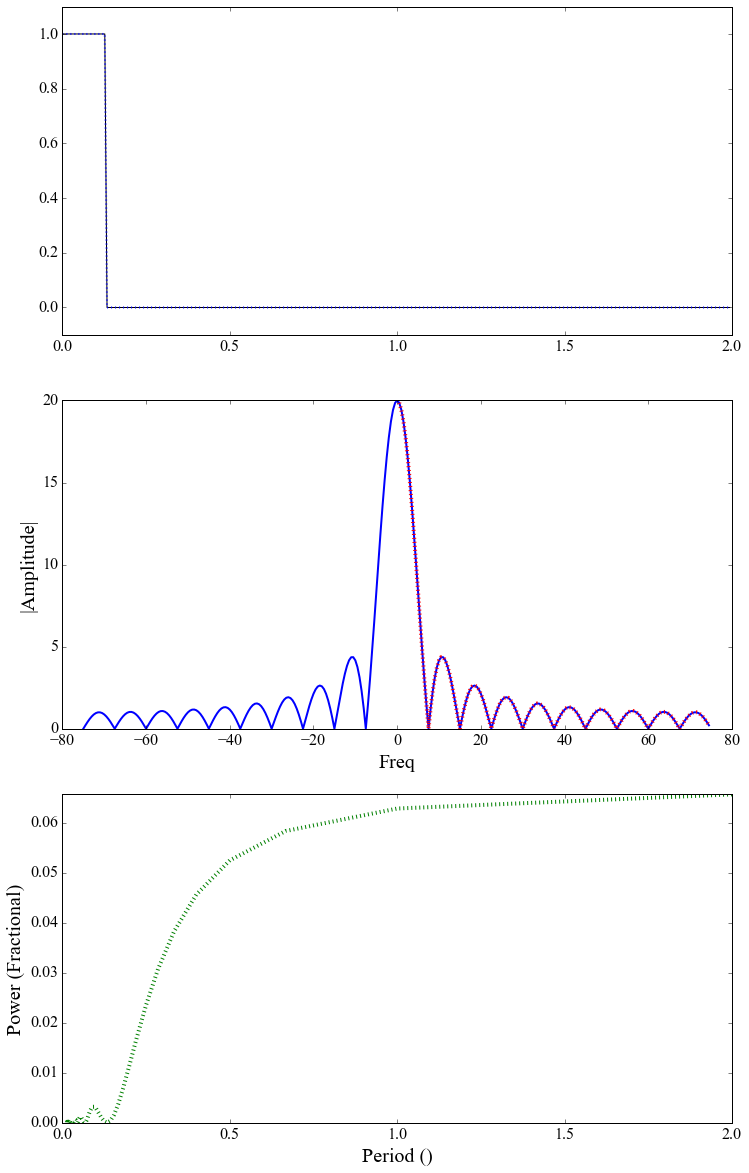

In [13]:
# test #3
#
# a simple pulse
#

nPulse = 20
y = np.ones(nPulse)
y = np.append(y, np.zeros(N_points-nPulse))

do_power_spectrum(x, y)


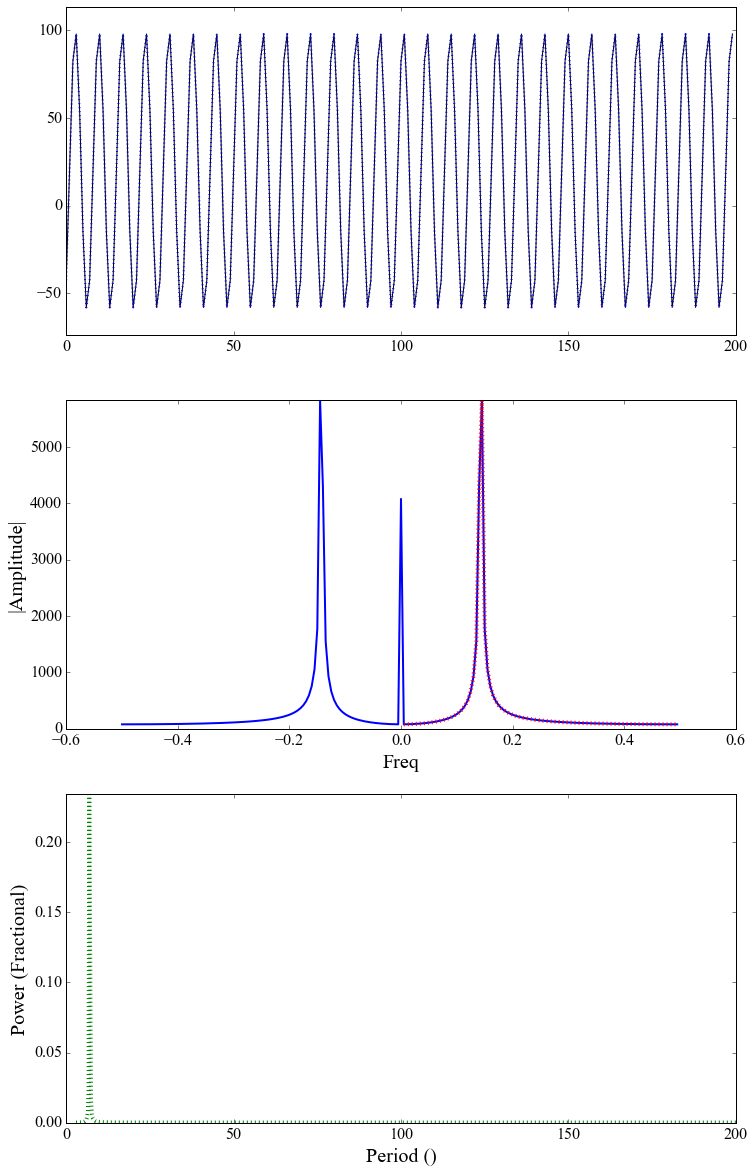

In [14]:
#
# test #4
#
# specific 7 day period
#

ff = 1/7.0

x = np.arange(0,200) # time vector

# all the power is in the zero component
#y = 200.0 + 80.0*np.sin(2*np.pi*ff*(x-15))

# power evenly distributed ...
y = 20.0 + 80.0*np.sin(2*np.pi*ff*(x-15))

# now, all the power is in the main frequency
#y = 0.0 + 80.0*np.sin(2*np.pi*ff*(x-15))

do_power_spectrum(x, y)

grabbed  daily_totals  new users from:  2016-05-01  to  2016-11-28


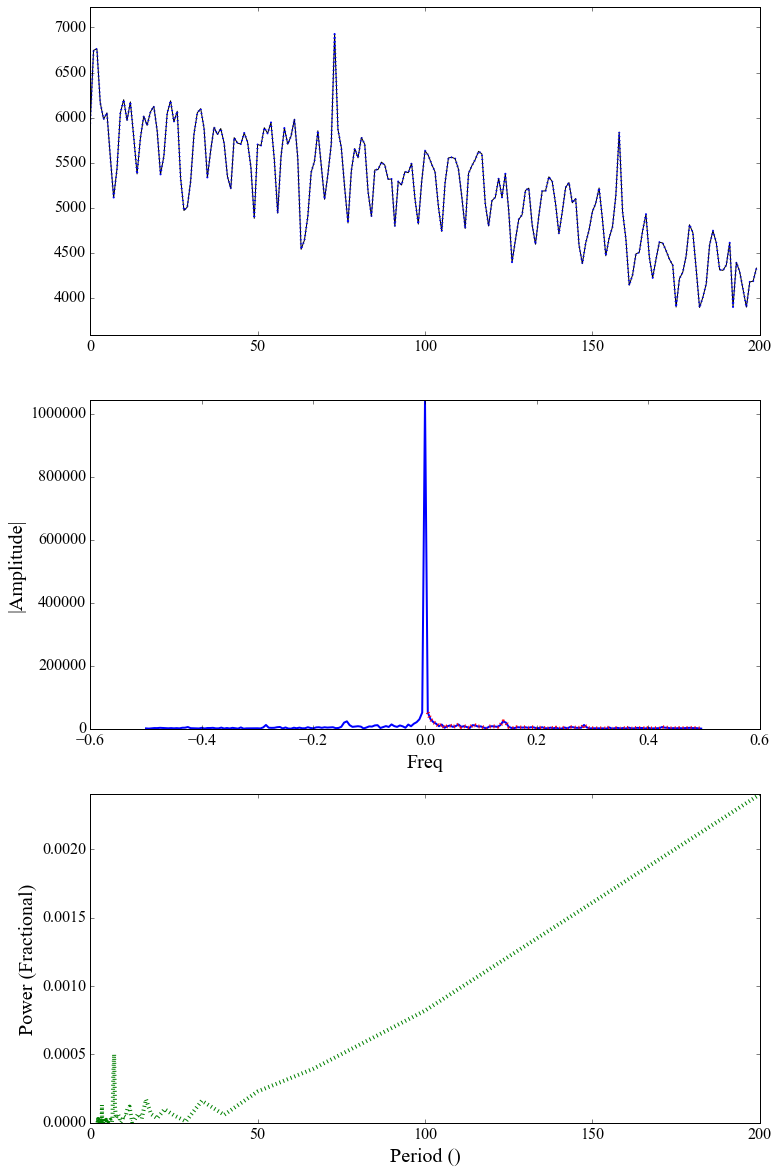

In [15]:
#
# load data first
#

startdate = "2016-05-01"
enddate = DT.datetime.now().strftime("%Y-%m-%d")

# grab dataframe
thisDF = grabDF_new_users("daily_totals", startdate, enddate)
#print thisDF.tail(n=2)

do_power_spectrum(thisDF['daynum'].values, thisDF['NewUsers'].values)

grabbed  daily_totals  new users from:  2016-05-01  to  2016-11-20


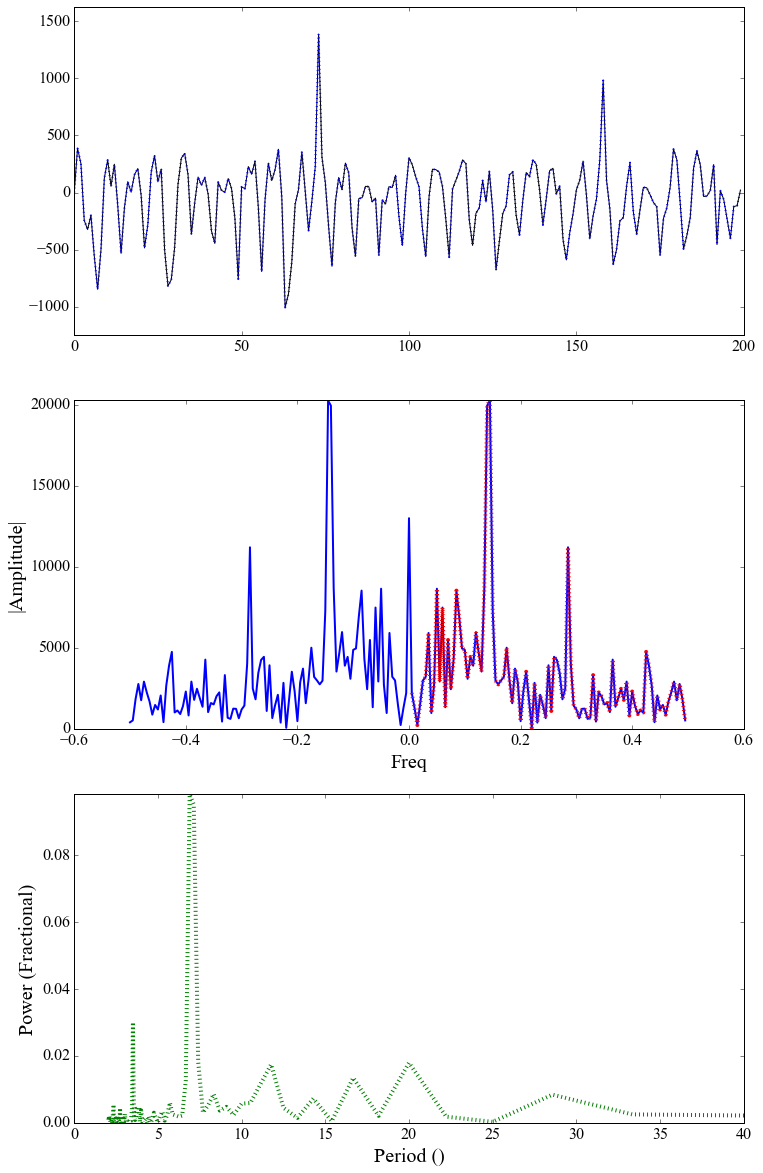

In [102]:
#
# the above fit shows that most of the power is in the trend component,
# let's take that out and see where the power is
#

startdate = "2016-05-01"
enddate = DT.datetime.now().strftime("%Y-%m-%d")

# grab dataframe
thisDF = grabDF_new_users("daily_totals", startdate, enddate)
#print thisDF.tail(n=2)

thisDF.smooth_and_fit()
#print thisDF.tail(n=5)
#plt.plot(thisDF['smooth'], 'r', linewidth=5.0)
#plt.plot(thisDF['localfit'], 'b', linewidth=5.0)

yflat = thisDF['NewUsers'].values - thisDF['smooth'].values
do_power_spectrum(thisDF['daynum'].values, yflat, powermax=40)